# QC Application

## Median Filter

time               0
depth              0
latitude           0
longitude          0
temperature        0
conductivity       0
salinity           0
oxy_conc           0
oxy_temperature    0
par                0
oxy_percentsat     0
oxy_conc_umkg      0
dtype: int64
time               0
depth              0
latitude           0
longitude          0
temperature        0
conductivity       0
salinity           0
oxy_conc           0
oxy_temperature    0
par                0
oxy_percentsat     0
oxy_conc_umkg      0
dtype: int64
depth                     0
latitude                  0
longitude                 0
temperature               0
conductivity              0
salinity                 17
oxy_conc                  0
oxy_temperature           0
par                       0
oxy_percentsat            0
oxy_conc_umkg             0
salinity_rolling_mean     0
salinity_rolling_std      1
upper_bound               1
lower_bound               1
dtype: int64

Quality control process completed fo

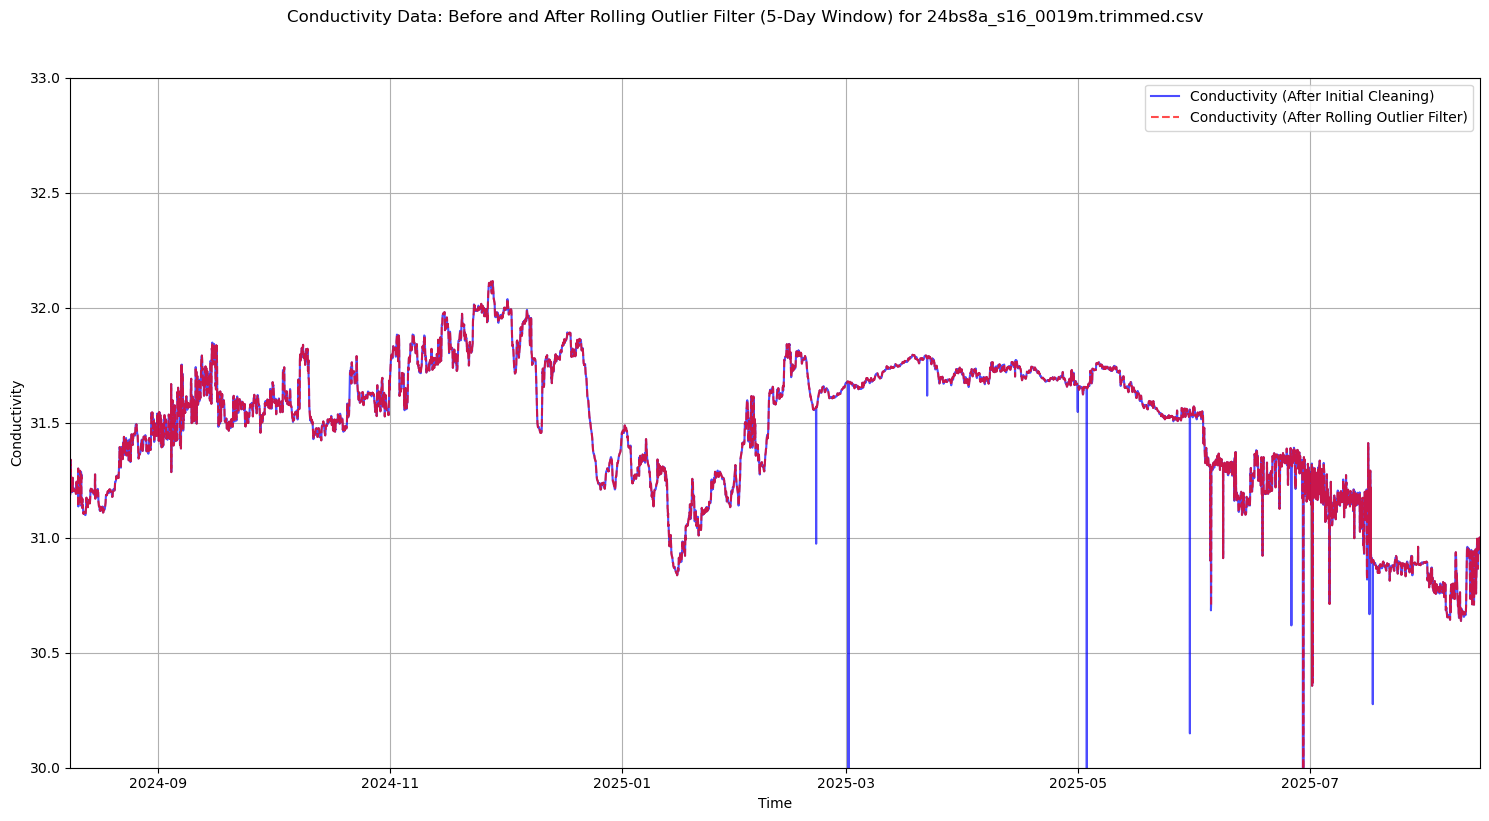

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime

# --- Step 1: Initial Load and Inspection ---
file_name = '24bs8a_s16_0019m.trimmed.csv'
df = pd.read_csv(file_name) # This line assumes the file is accessible in the current environment

# Convert 'time' column to datetime
df['time'] = pd.to_datetime(df['time'])
print(df.isnull().sum())

# --- Step 2: Clean Conductivity < 0.001 and Propagate NaNs ---
df_cleaned = df.copy()

# Replace conductivity and salinity values with NaN where conductivity is less than 0.001
# As discussed, salinity is also made NaN due to its correlation with anomalous conductivity
df_cleaned.loc[df_cleaned['conductivity'] < 0.01, ['conductivity', 'salinity']] = float('nan')

# Propagate NaNs from conductivity to temperature
# df_cleaned.loc[df_cleaned['conductivity'].isnull(), 'temperature'] = float('nan')
print(df_cleaned.isnull().sum())

# --- Step 3: Rolling Filter for Outliers in Conductivity ---

# Set the 'time' column as the index for rolling operations
df_cleaned_indexed = df_cleaned.set_index('time')

# Store original conductivity (after initial cleaning) for comparison in the next plot
original_conductivity_for_rolling_plot = df_cleaned_indexed['salinity'].copy()

# Define the rolling window size (5 days)
window_size = '7D'

# Calculate rolling mean and standard deviation for conductivity
df_cleaned_indexed['salinity_rolling_mean'] = df_cleaned_indexed['salinity'].rolling(window=window_size).mean()
df_cleaned_indexed['salinity_rolling_std'] = df_cleaned_indexed['salinity'].rolling(window=window_size).std()

# Define outlier bounds (5 standard deviations)
num_std_dev = 5
df_cleaned_indexed['upper_bound'] = df_cleaned_indexed['salinity_rolling_mean'] + num_std_dev * df_cleaned_indexed['salinity_rolling_std']
df_cleaned_indexed['lower_bound'] = df_cleaned_indexed['salinity_rolling_mean'] - num_std_dev * df_cleaned_indexed['salinity_rolling_std']

# Mark outliers: Replace conductivity values that are outside the bounds with NaN
outlier_mask = (df_cleaned_indexed['salinity'] > df_cleaned_indexed['upper_bound']) | \
               (df_cleaned_indexed['salinity'] < df_cleaned_indexed['lower_bound'])

df_cleaned_indexed.loc[outlier_mask, 'salinity'] = float('nan')
print(df_cleaned_indexed.isnull().sum())

# Reset index to get 'time' back as a column for plotting
df_cleaned_final = df_cleaned_indexed.reset_index()

# Plot: Conductivity before and after rolling filter
fig2, ax2 = plt.subplots(figsize=(15, 8))
fig2.suptitle(f'Conductivity Data: Before and After Rolling Outlier Filter (5-Day Window) for {file_name}', y=1.02)

ax2.plot(df_cleaned_final['time'], original_conductivity_for_rolling_plot.reset_index()['salinity'],
         label='Conductivity (After Initial Cleaning)', color='blue', alpha=0.7)
ax2.plot(df_cleaned_final['time'], df_cleaned_final['salinity'],
         label='Conductivity (After Rolling Outlier Filter)', color='red', linestyle='--', alpha=0.7)
ax2.set_ylim([30.0,33])
ax2.set_xlim([df_cleaned.time.min(),df_cleaned.time.max()])
ax2.set_xlabel('Time')
ax2.set_ylabel('Conductivity')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig('rolling_outlier_plot_24bs8a_s16_0019m.png')
# plt.close(fig2) # This line was used to close the figure and free memory in the execution environment

print("\nQuality control process completed for the new file.")

In [12]:
df_cleaned_final.to_csv(file_name.replace('trimmed','filtered'))